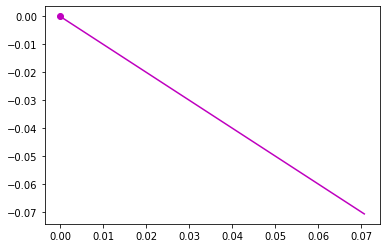

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from math import cos,sin
x0 = np.array([0,0,-np.pi/4.])
d = np.array([0,0.1])

plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.show()

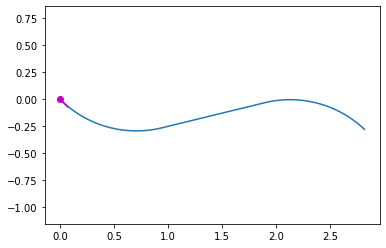

In [2]:
def f(x,u):
    return(np.array([u[0]*cos(x[2]),u[0]*sin(x[2]),u[0]*u[1]]))

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

uv = np.array([[1.,1.],[1.,0.],[1.,-1.],[1.,0.]])
tv = np.array([0.,1.,2.,3.])
ut = interp1d(tv,uv,axis=0,kind='previous')

def fc(t,x):
    u = ut(t)
    return(f(x,u))

te=np.linspace(0.,max(tv),100)
r = solve_ivp(fc,(min(te),max(te)),x0,t_eval=te)
plt.plot(r.y[0,:],r.y[1,:])
plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.axis('equal')
plt.show()

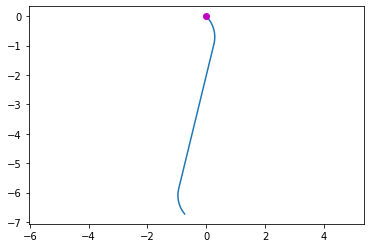

In [3]:
# define decision variable as vector of [time,curv,time,curv,time,curv]
z = np.array([1.,-1.,5.,0.,1.,1.])

def path(z):
    # make sure it has even number of elements
    nz = len(z)
    assert(nz%2==0)
    # curvature values
    kv = z[range(1,nz,2)]
    dv = z[range(0,nz,2)]
    #assert(all(dv>0))
    dv = [max(v,0) for v in dv]
    nv = len(kv)
    uv = np.vstack((np.ones((1,nv+1)),np.hstack((kv,0.))))
    tv = np.cumsum(np.append(0,dv))
    te=np.linspace(0.,max(tv),100)
    ut = interp1d(tv,uv,axis=1,kind='previous',bounds_error=False,fill_value='extrapolate')
    def fc(t,x):
        #print(dv,tv,t)
        u = ut(t)
        return(f(x,u))
    r = solve_ivp(fc,(min(te),max(te)),x0,t_eval=te)
    return(r.y)

p = path(z)

plt.plot(p[0,:],p[1,:])
plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.axis('equal')
plt.show()

In [4]:
from scipy.linalg import norm

p_goal = np.array([6.,4.,-np.pi/4])

def J(z):
    p = path(z)
    return(norm(p[0:3,-1]-p_goal))

print(J(z))

12.662599419995676


In [19]:
curv_lim = 1.0
bnds = [b for ii in range(len(z)//2) for b in [(0.1,10.0),(-curv_lim,curv_lim)]]
bnds

[(0.1, 10.0), (-1.0, 1.0), (0.1, 10.0), (-1.0, 1.0), (0.1, 10.0), (-1.0, 1.0)]

In [20]:
from scipy.optimize import minimize

r = minimize(J,z,method='SLSQP',bounds=bnds)
print(r)

     fun: 0.8771018893642956
     jac: array([  0.60086793,  -8.44302468,   0.60086793, -16.69571625,
         0.60086793,  -1.57376175])
 message: 'Optimization terminated successfully.'
    nfev: 467
     nit: 37
    njev: 36
  status: 0
 success: True
       x: array([ 1.77488245,  1.        ,  4.84840923, -0.09232769,  1.77488245,
       -0.99920572])


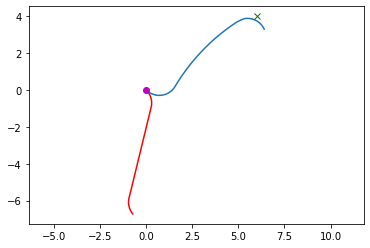

In [21]:
popt = path(r.x)
plt.plot(p[0,:],p[1,:],'r')
plt.plot(popt[0,:],popt[1,:])
plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.plot(p_goal[0],p_goal[1],'gx')
plt.axis('equal')
plt.show()

In [28]:
def Jsp(z):
    tf = sum(z[range(0,len(z),2)])
    ge = J(z)
    return(0.1*tf+100.*ge)

print(Jsp(z))

1266.9599419995677


In [29]:
r = minimize(Jsp,z,method='SLSQP',bounds=bnds)
print(r)

     fun: 0.9477236414077728
     jac: array([   52.03896151,   563.55217063,    52.03896151, -3749.8119396 ,
          52.03896151,  -118.75094951])
 message: 'Optimization terminated successfully.'
    nfev: 872
     nit: 81
    njev: 77
  status: 0
 success: True
       x: array([ 2.95690202,  0.49354197,  3.55767034,  0.28777158,  2.95690207,
       -0.83067603])


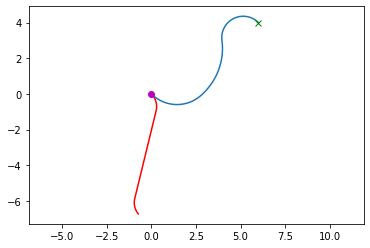

In [30]:
popt = path(r.x)
plt.plot(p[0,:],p[1,:],'r')
plt.plot(popt[0,:],popt[1,:])
plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.plot(p_goal[0],p_goal[1],'gx')
plt.axis('equal')
plt.show()

In [31]:
def Jspbdd(z):
    J = Jsp(z)
    for (ii,(lo,hi)) in enumerate(bnds):
        if z[ii]>hi:
            J = J + 1e2*(z[ii]-hi)
        elif z[ii]<lo:
            J = J + 1e2*(lo-z[ii])
    return(J)

print(Jspbdd(z))

1266.9599419995677


In [32]:
r = minimize(Jspbdd,z,method='Powell')
print(r)

   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.40361371e-03,  5.89951766e-04, -1.75294530e-04,
         5.37044998e-03, -2.05402651e-03, -2.29285042e-02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.63575047e-03,  2.29508764e-03,  4.74150345e-03,
        -1.56079940e-03,  3.45044948e-02, -1.84581042e-03],
       [ 2.23669959e-10,  1.96671288e-10,  3.90173007e-10,
        -1.29274630e-10, -5.95769569e-10, -1.75793061e-10]])
     fun: 109.79733116118358
 message: 'Optimization terminated successfully.'
    nfev: 1561
     nit: 13
  status: 0
 success: True
       x: array([ 0.4429173 ,  0.94484229,  1.41917256,  0.98369605,  5.99498018,
       -0.13587359])


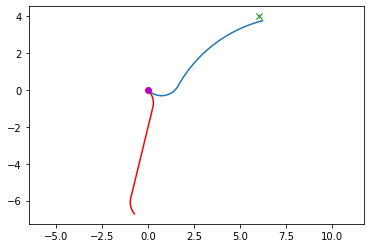

In [33]:
popt = path(r.x)
plt.plot(p[0,:],p[1,:],'r')
plt.plot(popt[0,:],popt[1,:])
plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.plot(p_goal[0],p_goal[1],'gx')
plt.axis('equal')
plt.show()